## Purpose ##

This notebook contains code that aims to use computer vision to read the state of the screen while playing video games (Trackmania United Forever, in this case), so that information about the game world can be sent to a ML algorithm that processes the data. The goal is to have tangible outputs that can then be fed back into the game. These outputs should then undergo processing to optimize gameplay in an iterative process, such as generational learning.

Rough sequence of events:
- Grab screen data
- Process screen data into outputs
- Feed outputs back into game
- Optimize outputs

### Step 1: Capture Screen ###

In [18]:
import numpy as np
from PIL import ImageGrab
import cv2
import time

def screen_record(): 
    last_time = time.time()
    while(True):
        # 1280x960 windowed mode
        printscreen =  np.array(ImageGrab.grab(bbox=(0,40,1280,960)))
        print('loop took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        cv2.imshow('window',cv2.cvtColor(printscreen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
#screen_record()

Now that the POC is shown to have worked, setup image processing for edge detection.

### Step 2: Edge Detection of Image ###

In [29]:
import numpy as np
from PIL import ImageGrab
import cv2
import time

def process_img(image):
    original_image = image
    # convert to gray
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edge detection
    processed_img =  cv2.Canny(processed_img, threshold1=200, threshold2=300)
    return processed_img

def main():
    last_time = time.time()
    while True:
        screen =  np.array(ImageGrab.grab(bbox=(0,40,1280,960)))
        #print('Frame took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        new_screen = process_img(screen)
        cv2.imshow('window', new_screen)
        #cv2.imshow('window',cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

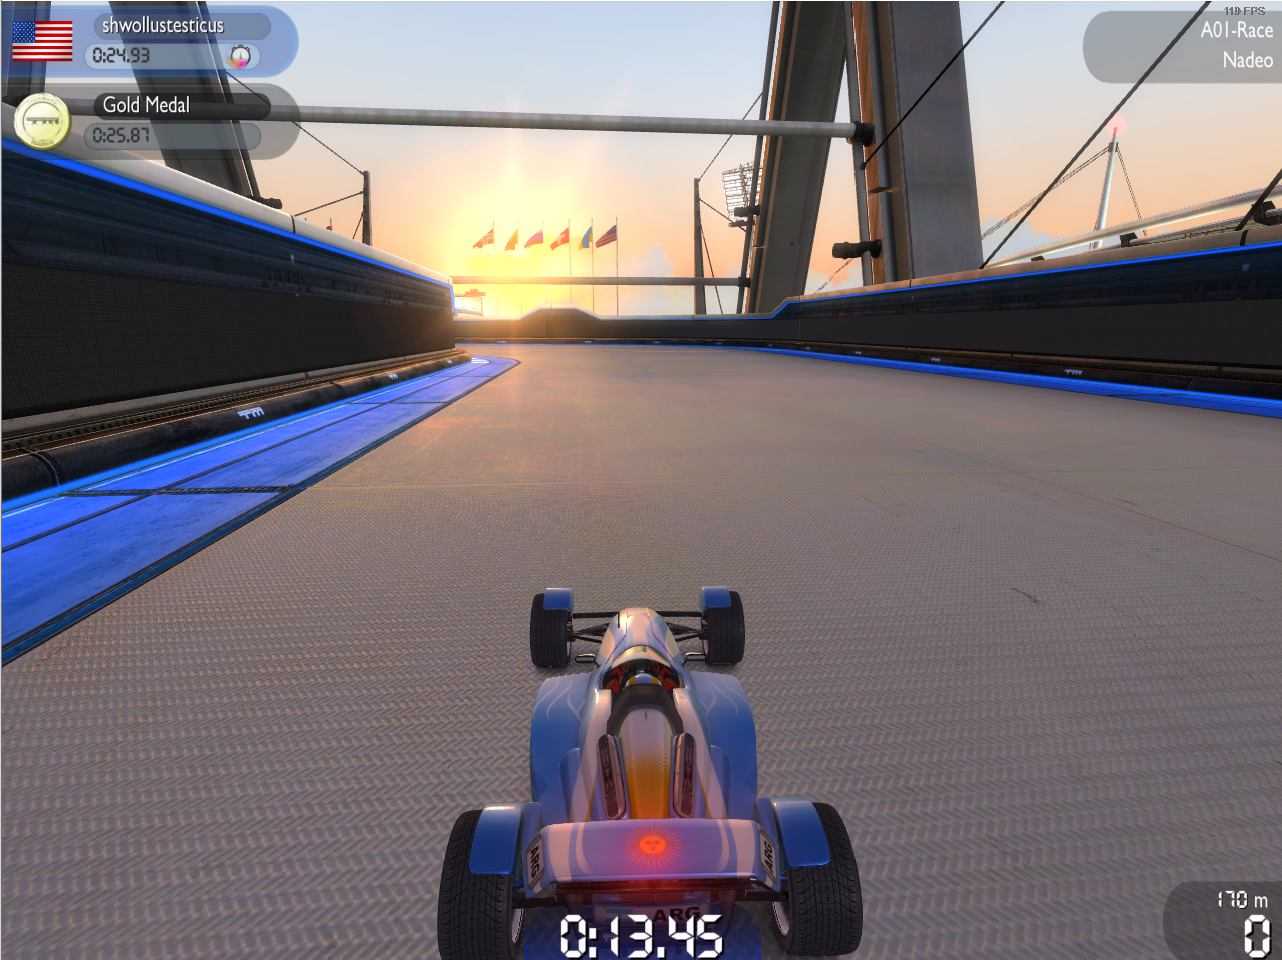

In [28]:
main()
##from IPython.display import Image
##Image(filename='C:\\Users\\jusla\\Pictures\\Screenshots\\edge-detection.png') 

### Step 3: Feed input to game ###

Start with a POC

In [31]:
import pyautogui
import time
# gives us time to get situated in the game
for i in list(range(4))[::-1]:
    print(i+1)
    time.sleep(1)

print('down')
pyautogui.keyDown('w') 
time.sleep(3)
print('up')
pyautogui.keyUp('w') 

4
3
2
1
down
up


Doesn't work in most cases. Direct input needed.

In [48]:
# direct inputs
# source to this solution and code:
# http://stackoverflow.com/questions/14489013/simulate-python-keypresses-for-controlling-a-game
# http://www.gamespp.com/directx/directInputKeyboardScanCodes.html

import ctypes
import time

SendInput = ctypes.windll.user32.SendInput

#Reasigning for games that use arrow keys
#W = 0x11
#A = 0x1E
#S = 0x1F
#D = 0x20
W = 0xC8   #Up arrow
A = 0xCB   #Left arrow
S = 0xD0   #Down arrow
D = 0xCD   #Right arrow

# C struct redefinitions 
PUL = ctypes.POINTER(ctypes.c_ulong)
class KeyBdInput(ctypes.Structure):
    _fields_ = [("wVk", ctypes.c_ushort),
                ("wScan", ctypes.c_ushort),
                ("dwFlags", ctypes.c_ulong),
                ("time", ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class HardwareInput(ctypes.Structure):
    _fields_ = [("uMsg", ctypes.c_ulong),
                ("wParamL", ctypes.c_short),
                ("wParamH", ctypes.c_ushort)]

class MouseInput(ctypes.Structure):
    _fields_ = [("dx", ctypes.c_long),
                ("dy", ctypes.c_long),
                ("mouseData", ctypes.c_ulong),
                ("dwFlags", ctypes.c_ulong),
                ("time",ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class Input_I(ctypes.Union):
    _fields_ = [("ki", KeyBdInput),
                 ("mi", MouseInput),
                 ("hi", HardwareInput)]

class Input(ctypes.Structure):
    _fields_ = [("type", ctypes.c_ulong),
                ("ii", Input_I)]

# Actuals Functions

def PressKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

def ReleaseKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008 | 0x0002, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

if __name__ == '__main__':
    PressKey(0x11)
    time.sleep(1)
    ReleaseKey(0x11)
    time.sleep(1)

In [59]:
import numpy as np
from PIL import ImageGrab
import cv2
import time
import pyautogui
from directinput import PressKey, ReleaseKey, W, A, S, D    #Using this requires saving the code in cell above as a file named directkeys.py

def process_img(image):
    original_image = image
    # convert to gray
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edge detection
    processed_img =  cv2.Canny(processed_img, threshold1 = 200, threshold2=300)
    return processed_img

def main():
    
    #Countdown to let us get to the game
    for i in list(range(4))[::-1]:
        print(i+1)
        time.sleep(1)

    last_time = time.time()
    while True:
        PressKey(W)
        screen =  np.array(ImageGrab.grab(bbox=(0,40,1280,960)))
        #print('Frame took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        new_screen = process_img(screen)
        cv2.imshow('window', new_screen)
        #cv2.imshow('window',cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
#main()

### Step 4: Improve Edge Detection ###

We start off by implementing self-driving behavior based on edge detection of the boundaries of the track in Trackmania. Instead of looking at the entire screen, we place a mask over the screen and reduce the processed area to be only that of the track and the vehicle (roughly).

In [64]:
import numpy as np
from PIL import ImageGrab
import cv2
import time
import pyautogui
from directinput import PressKey, ReleaseKey, W, A, S, D


def process_img(original_image):
    processed_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)
    
    vertices = np.array([[10,800],[10,480],[480,320],[800,320],[1280,480],[1280,800],
                         ], np.int32)
    processed_img = roi(processed_img, [vertices])
    
    return processed_img

def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

def main():
    last_time = time.time()
    while(True):
        screen =  np.array(ImageGrab.grab(bbox=(0,40, 1280, 960)))
        new_screen = process_img(screen)
        print('Loop took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        cv2.imshow('window', new_screen)
        #cv2.imshow('window2', cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

main()

Loop took 0.07995772361755371 seconds
Loop took 0.11558938026428223 seconds
Loop took 0.0984048843383789 seconds
Loop took 0.1098029613494873 seconds
Loop took 0.10443711280822754 seconds
Loop took 0.10844159126281738 seconds
Loop took 0.10109972953796387 seconds
Loop took 0.10821223258972168 seconds
Loop took 0.12111020088195801 seconds
Loop took 0.11289548873901367 seconds
Loop took 0.11115145683288574 seconds
Loop took 0.09702563285827637 seconds
Loop took 0.0989987850189209 seconds
Loop took 0.09184885025024414 seconds
Loop took 0.09142613410949707 seconds
Loop took 0.09055972099304199 seconds
Loop took 0.09833955764770508 seconds
Loop took 0.07652640342712402 seconds
Loop took 0.10185909271240234 seconds
Loop took 0.11528539657592773 seconds
Loop took 0.10809707641601562 seconds
Loop took 0.11510539054870605 seconds


Now that the region of interest is more dialed in, we will attempt to make the edges of the track stand out even more. 

In [3]:
import numpy as np
from PIL import ImageGrab
import cv2
import time
import pyautogui
from directinput import PressKey, ReleaseKey, W, A, S, D


def process_img(original_image):
    processed_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)
    vertices = np.array([[10,800],[10,480],[480,320],[800,320],[1280,480],[1280,800],
                         ], np.int32)

    processed_img = cv2.GaussianBlur(processed_img,(5,5),0)
    processed_img = roi(processed_img, [vertices])

    # more info: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
    #                          edges       rho   theta   thresh         # min length, max gap:        
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180,      20,         15)
    draw_lines(processed_img,lines)
    return processed_img

def draw_lines(img,lines):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 3)
        

def process_img(original_image):
    processed_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)
    vertices = np.array([[10,800],[10,480],[480,320],[800,320],[1280,480],[1280,800],
                         ], np.int32)
    processed_img = cv2.GaussianBlur(processed_img, (5,5), 0)
    processed_img = roi(processed_img, [vertices])

    # more info: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
    #                          edges       rho   theta   thresh         # min length, max gap:        
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180,      20,         15)
    draw_lines(processed_img,lines)
    return processed_img


def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked


def main():
    last_time = time.time()
    while(True):
        screen =  np.array(ImageGrab.grab(bbox=(0,40, 1280, 960)))
        new_screen = process_img(screen)
        #print('Loop took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        cv2.imshow('window', new_screen)
        #cv2.imshow('window2', cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
main()

Now we need to determine which lines set the boundaries of the track.

In [ ]:
def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
    try:

        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        min_y = min(ys)
        max_y = 960
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:

                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]

        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s)) 

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2]
    except Exception as e:
        print(str(e))

In [ ]:
import numpy as np
from PIL import ImageGrab
import cv2
import time
from numpy import ones,vstack
from numpy.linalg import lstsq
from directinput import PressKey, W, A, S, D
from statistics import mean

def roi(img, vertices):
    
    #blank mask:
    mask = np.zeros_like(img)   
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked = cv2.bitwise_and(img, mask)
    return masked


def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
    try:

        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        min_y = min(ys)
        max_y = 960
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:

                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]

        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s)) 

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2]
    except Exception as e:
        print(str(e))


def process_img(image):
    original_image = image
    # convert to gray
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edge detection
    processed_img =  cv2.Canny(processed_img, threshold1 = 200, threshold2=300)
    
    processed_img = cv2.GaussianBlur(processed_img,(5,5),0)
    
    vertices = np.array([[10,600],[10,480],[480,400],[800,400],[1280,480],[1280,600],
                         ], np.int32)

    processed_img = roi(processed_img, [vertices])

    # more info: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
    #                                     rho   theta   thresh  min length, max gap:        
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180,      20,       15)
    try:
        l1, l2 = draw_lanes(original_image,lines)
        cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 30)
        cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 30)
    except Exception as e:
        print(str(e))
        pass
    try:
        for coords in lines:
            coords = coords[0]
            try:
                cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
                
                
            except Exception as e:
                print(str(e))
    except Exception as e:
        pass

    return processed_img,original_image



def main():
    last_time = time.time()
    while True:
        screen =  np.array(ImageGrab.grab(bbox=(0,40,1280,960)))
        #print('Frame took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        new_screen,original_image = process_img(screen)
        cv2.imshow('window', new_screen)
        cv2.imshow('window2',cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        #cv2.imshow('window',cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
            
main()

In [ ]:
import numpy as np
from PIL import ImageGrab
import cv2
import time
from numpy import ones,vstack
from numpy.linalg import lstsq
from directinput import ReleaseKey, PressKey, W, A, S, D
from statistics import mean


def roi(img, vertices):
    
    #blank mask:
   mask = np.zeros_like(img)   
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
   cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
   masked = cv2.bitwise_and(img, mask)
   return masked


def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
   try:

        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

         ys = []  
       for i in lines:
          for ii in i:
               ys += [ii[1],ii[3]]
       min_y = min(ys)
        max_y = 960
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:

                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]

        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s)) 

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2], lane1_id, lane2_id
    except Exception as e:
        print(str(e))
       
    
def process_img(image):
    original_image = image
    # convert to gray
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edge detection
    processed_img =  cv2.Canny(processed_img, threshold1 = 200, threshold2=300)
    
    processed_img = cv2.GaussianBlur(processed_img,(5,5),0)
    
    vertices = np.array([[10,600],[10,480],[480,400],[800,400],[1280,480],[1280,600],
                         ], np.int32)

    processed_img = roi(processed_img, [vertices])

    # more info: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
    #                                     rho   theta   thresh  min length, max gap:        
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180,      20,       15)
    m1 = 0
    m2 = 0
    try:
        l1, l2, m1,m2 = draw_lanes(original_image,lines)
        cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 30)
        cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 30)
    except Exception as e:
        print(str(e))
        pass
    try:
        for coords in lines:
            coords = coords[0]
            try:
                cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
                
                
            except Exception as e:
                print(str(e))
    except Exception as e:
        pass

    return processed_img,original_image, m1, m2


def straight():
    PressKey(W)
    ReleaseKey(A)
    ReleaseKey(D)

    
def left():
    PressKey(A)
    #ReleaseKey(W)
    ReleaseKey(D)

    
def right():
    PressKey(D)
    ReleaseKey(A)
    #ReleaseKey(W)

    
def slow_ya_roll():
    ReleaseKey(W)
    ReleaseKey(A)
    ReleaseKey(D)
    
    
def main():
    last_time = time.time()
    while True:
        screen =  np.array(ImageGrab.grab(bbox=(0,40,1280,960)))
        #print('Frame took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        new_screen,original_image, m1, m2 = process_img(screen)
        #cv2.imshow('window', new_screen)
        cv2.imshow('window2',cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

        if m1 < 0 and m2 < 0:
            right()
            print("Right")
        elif m1 > 0  and m2 > 0:
            left()
            print("Left")
        else:
            straight()
            print("Straight")

        #cv2.imshow('window',cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

main()

###### Step 8: Setting Up ML Framework ###

We will be using a Deep Learning approach in this section. 

In [ ]:
# Code saved as grabscreen.py
# Done by Frannecklp

import cv2
import numpy as np
import win32gui, win32ui, win32con, win32api

def grab_screen(region=None):

    hwin = win32gui.GetDesktopWindow()

    if region:
            left,top,x2,y2 = region
            width = x2 - left + 1
            height = y2 - top + 1
    else:
        width = win32api.GetSystemMetrics(win32con.SM_CXVIRTUALSCREEN)
        height = win32api.GetSystemMetrics(win32con.SM_CYVIRTUALSCREEN)
        left = win32api.GetSystemMetrics(win32con.SM_XVIRTUALSCREEN)
        top = win32api.GetSystemMetrics(win32con.SM_YVIRTUALSCREEN)

    hwindc = win32gui.GetWindowDC(hwin)
    srcdc = win32ui.CreateDCFromHandle(hwindc)
    memdc = srcdc.CreateCompatibleDC()
    bmp = win32ui.CreateBitmap()
    bmp.CreateCompatibleBitmap(srcdc, width, height)
    memdc.SelectObject(bmp)
    memdc.BitBlt((0, 0), (width, height), srcdc, (left, top), win32con.SRCCOPY)
    
    signedIntsArray = bmp.GetBitmapBits(True)
    img = np.fromstring(signedIntsArray, dtype='uint8')
    img.shape = (height,width,4)

    srcdc.DeleteDC()
    memdc.DeleteDC()
    win32gui.ReleaseDC(hwin, hwindc)
    win32gui.DeleteObject(bmp.GetHandle())

    return cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

# Code saved as draw_lanes.py
def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
    try:

        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        min_y = min(ys)
        max_y = 960
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:

                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]

        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s)) 

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2], lane1_id, lane2_id
    except Exception as e:
        print(str(e))

In [ ]:
# getkeys.py
# Citation: Box Of Hats (https://github.com/Box-Of-Hats )

import win32api as wapi
import time

keyList = ["\b"]
for char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ 123456789,.'APS$/\\":
    keyList.append(char)

def key_check():
    keys = []
    for key in keyList:
        if wapi.GetAsyncKeyState(ord(key)):
            keys.append(key)
    return keys

In [24]:
import numpy as np
from grabscreen import grab_screen
import cv2
import time
from getkeys import key_check
import os


def keys_to_output(keys):
    '''
    Convert keys to a ...multi-hot... array

    [A,W,D] boolean values.
    '''
    output = [0,0,0]
    
    if 'A' in keys or '%' in keys:
        output[0] = 1
    elif 'D' in keys or "'" in keys:
        output[2] = 1
    else:
        output[1] = 1
    return output

file_name = 'training_data.npy'

if os.path.isfile(file_name):
    print('File exists, loading previous data!')
    training_data = list(np.load(file_name, allow_pickle=True))
else:
    print('File does not exist, starting fresh!')
    training_data = []
    
def main():

    for i in list(range(4))[::-1]:
        print(i+1)
        time.sleep(1)
        
    while(True):
        # 800x600 windowed mode
        screen = grab_screen(region=(0,40,1280,960))
        last_time = time.time()
        screen = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
        # resize to something a bit more acceptable for a CNN
        screen = cv2.resize(screen, (80,60))
        keys = key_check()
        output = keys_to_output(keys)
        training_data.append([screen,output])
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

        if len(training_data) % 500 == 0:
            print(len(training_data))
            np.save(file_name,training_data)
            
main()

File exists, loading previous data!
4
3
2
1


KeyboardInterrupt: 

In [ ]:
file_name = 'training_data.npy'
training_data = list(np.load(file_name, allow_pickle=True))
training_data